## Exploring data


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

### movie_gross CSV file

In [180]:
movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### tmdb_movie CSV file

In [227]:
tmdb_movie = pd.read_csv("imdb_with_movie_gross_V2.csv")
tmdb_movie.head()

,genre_ids,id_x,popularity,release_date_x,vote_average,vote_count,id_y,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
0,"[14, 12, 16, 10751]",10191,28.734,2010-03-26,7.7,7610,30,How To Train Your Dragon,165000000.0,217581232.0,494870992.0,329870992,299.921813
1,"[12, 28, 878]",10138,28.515,2010-05-07,6.8,12368,15,Iron Man 2,170000000.0,312433331.0,621156389.0,451156389,365.386111
2,"[16, 35, 10751]",862,28.005,1995-11-22,7.9,10174,37,Toy Story,30000000.0,191796233.0,364545516.0,334545516,1215.151720
3,"[28, 878, 12]",27205,27.920,2010-07-16,8.3,22186,38,Inception,160000000.0,292576195.0,835524642.0,675524642,522.202901
4,"[12, 14, 10751]",32657,26.691,2010-02-11,6.1,4229,17,Percy Jackson & The Olympians: The Lightning T...,95000000.0,88768303.0,223050874.0,128050874,234.790394


In [228]:
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          2180 non-null   object 
 1   id_x               2180 non-null   int64  
 2   popularity         2180 non-null   float64
 3   release_date_x     2180 non-null   object 
 4   vote_average       2180 non-null   float64
 5   vote_count         2180 non-null   int64  
 6   id_y               2180 non-null   int64  
 7   movie              2180 non-null   object 
 8   production_budget  2180 non-null   float64
 9   domestic_gross     2180 non-null   float64
 10  worldwide_gross    2180 non-null   float64
 11  profit             2180 non-null   int64  
 12  roi                2180 non-null   float64
dtypes: float64(6), int64(4), object(3)
memory usage: 221.5+ KB


#### Filter 1: movies released between 2010 and 2018

In [229]:
# Filtering movies that are released between 2010 and 2018
tmdb_movie['release_year'] = tmdb_movie['release_date_x'].str[:4].astype(int)
tmdb_movie = tmdb_movie.loc[(tmdb_movie['release_year'] >= 2010) & (tmdb_movie['release_year'] <= 2018)]
tmdb_movie['release_year'].value_counts()

release_year
2014    273
2011    272
2015    269
2013    257
2010    245
2016    233
2012    226
2017    177
2018    164
Name: count, dtype: int64

#### Changing `genre_ids` to `genre`

From calling the `.info()` method, there seems to be no missing values to deal with. However, the `genre_ids` column is notable because it contains strings that appear to be lists with numerical values.

Since all `genre_ids` are encoded, we match the numeric codes to the actual genre strings, based on information found [here](https://www.themoviedb.org/talk/5f58b094befb0900355684a6), and create another column called `genre` that contains a list of genres.

In [94]:
# A dictionary containing the genre_ids as keys and genres as values
tmdb_genre_list = {
            '28': 'Action',
            '12': 'Adventure',
            '16': 'Animation',
            '35': 'Comedy',
            '80': 'Crime',
            '99': 'Documentary',
            '18': 'Drama',
            '10751': 'Family',
            '14': 'Fantasy',
            '36': 'History',
            '27': 'Horror',
            '10402': 'Music',
            '9648': 'Mystery',
            '10749': 'Romance',
            '878': 'ScienceFiction',
            '10770': 'TVMovie',
            '53': 'Thriller',
            '10752': 'War',
            '37': 'Western'
}

In [230]:
# Changing format of genre_ids to a list
# Note that the numerical values are still in strings

tmdb_movie['genre_ids'] = tmdb_movie['genre_ids'].str.strip('][').str.split(', ')
tmdb_movie['genre_ids'].head()

0    [14, 12, 16, 10751]
1          [12, 28, 878]
3          [28, 878, 12]
4        [12, 14, 10751]
6        [16, 10751, 35]
Name: genre_ids, dtype: object

In [231]:
# Changing the numerical values to actual genres
# Creating a function to match with the genre list created above.
# If the number is not in the list, return 'Unknown'
def clean_genre(genre):
    new_genre = []
    for id in genre:
        if id in tmdb_genre_list.keys():
            new_genre.append(tmdb_genre_list[id])
        else:
            new_genre = 'Unknown'
    return new_genre

# Using this function to change numbers to genres
tmdb_movie['genre'] = tmdb_movie['genre_ids'].map(clean_genre)



#### Filter 2: Removing movies that do not have any genres assigned

One of the notable categories is the **Unknown** category. This category may contain a numeric genre_id that is not specified in the `tmdb_genre_list` dictionary, or have no numeric id. Since there are 2479 entries with the **Unknown** out of about 26500, we decide to drop the movies that have the **Unknown** category.

In [232]:
# Dropping the Unknown movies
tmdb_movie = tmdb_movie.loc[tmdb_movie['genre'] != 'Unknown']
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2059 entries, 0 to 2179
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          2059 non-null   object 
 1   id_x               2059 non-null   int64  
 2   popularity         2059 non-null   float64
 3   release_date_x     2059 non-null   object 
 4   vote_average       2059 non-null   float64
 5   vote_count         2059 non-null   int64  
 6   id_y               2059 non-null   int64  
 7   movie              2059 non-null   object 
 8   production_budget  2059 non-null   float64
 9   domestic_gross     2059 non-null   float64
 10  worldwide_gross    2059 non-null   float64
 11  profit             2059 non-null   int64  
 12  roi                2059 non-null   float64
 13  release_year       2059 non-null   int64  
 14  genre              2059 non-null   object 
dtypes: float64(6), int64(5), object(4)
memory usage: 257.4+ KB


#### Separating `genre` into individual columns

In [233]:
tmdb_movie = tmdb_movie.reset_index()

In [234]:
# Creating 7 columns to store individaul genres for movies that have more than one genre
split = pd.DataFrame(tmdb_movie['genre'].to_list(), columns = ['main_genre', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7'])
tmdb_movie = pd.concat([tmdb_movie, split], axis=1)
tmdb_movie.head()

,index,genre_ids,id_x,popularity,release_date_x,vote_average,vote_count,id_y,movie,production_budget,...,roi,release_year,genre,main_genre,genre2,genre3,genre4,genre5,genre6,genre7
0,0,"[14, 12, 16, 10751]",10191,28.734,2010-03-26,7.7,7610,30,How To Train Your Dragon,165000000.0,...,299.921813,2010,"[Fantasy, Adventure, Animation, Family]",Fantasy,Adventure,Animation,Family,None,None,None
1,1,"[12, 28, 878]",10138,28.515,2010-05-07,6.8,12368,15,Iron Man 2,170000000.0,...,365.386111,2010,"[Adventure, Action, ScienceFiction]",Adventure,Action,ScienceFiction,None,None,None,None
2,3,"[28, 878, 12]",27205,27.920,2010-07-16,8.3,22186,38,Inception,160000000.0,...,522.202901,2010,"[Action, ScienceFiction, Adventure]",Action,ScienceFiction,Adventure,None,None,None,None
3,4,"[12, 14, 10751]",32657,26.691,2010-02-11,6.1,4229,17,Percy Jackson & The Olympians: The Lightning T...,95000000.0,...,234.790394,2010,"[Adventure, Fantasy, Family]",Adventure,Fantasy,Family,None,None,None,None
4,6,"[16, 10751, 35]",10193,24.445,2010-06-17,7.7,8340,47,Toy Story 3,200000000.0,...,534.439761,2010,"[Animation, Family, Comedy]",Animation,Family,Comedy,None,None,None,None


In [235]:
# First, creating a dictionary with genres and counts
top_7_genres_index = list(tmdb_movie['main_genre'].value_counts()[:7].keys())
top_7_genre_counts = tmdb_movie['main_genre'].value_counts()[:7]
top_7_genres = dict(zip(top_7_genres_index, top_7_genre_counts))

In [236]:
top_7_genres

{'Drama': 516,
 'Comedy': 343,
 'Action': 317,
 'Horror': 159,
 'Thriller': 152,
 'Adventure': 106,
 'Crime': 79}

#### (Probably not for the final notebook but,) Calculating popularity and vote average

##### Only focusing on movies with more than 10 votes

In [237]:
# Filtering to only analyze from movies with more than 10 votes
reviews_more_than_10 = tmdb_movie.loc[tmdb_movie['vote_count'] > 10]
reviews_more_than_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 0 to 2049
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1750 non-null   int64  
 1   genre_ids          1750 non-null   object 
 2   id_x               1750 non-null   int64  
 3   popularity         1750 non-null   float64
 4   release_date_x     1750 non-null   object 
 5   vote_average       1750 non-null   float64
 6   vote_count         1750 non-null   int64  
 7   id_y               1750 non-null   int64  
 8   movie              1750 non-null   object 
 9   production_budget  1750 non-null   float64
 10  domestic_gross     1750 non-null   float64
 11  worldwide_gross    1750 non-null   float64
 12  profit             1750 non-null   int64  
 13  roi                1750 non-null   float64
 14  release_year       1750 non-null   int64  
 15  genre              1750 non-null   object 
 16  main_genre         1750 non-n

In [238]:
# Checking number of movies per genre
reviews_more_than_10['main_genre'].value_counts()

main_genre
Drama             440
Comedy            310
Action            299
Horror            126
Thriller          119
Adventure          96
Crime              74
Animation          55
Romance            46
ScienceFiction     43
Fantasy            38
Documentary        27
Family             22
Mystery            20
History            13
War                12
Music               6
Western             3
TVMovie             1
Name: count, dtype: int64

##### Number of movies in top 7 genres

Text(0, 0.5, 'Number of Movies')

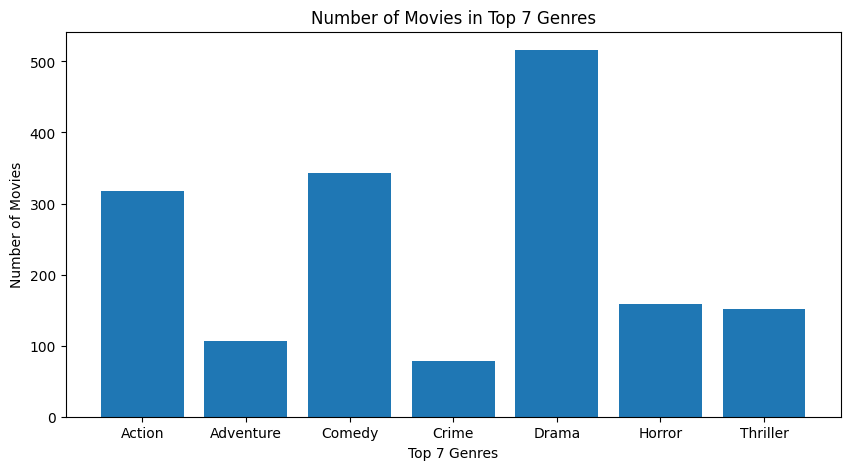

In [239]:
# Visualizing the number of movies in top 7 movie genres

# Sorting them alphabetically for the visualization
top_7_genres_index.sort()
top_7_genres_sorted = {i: top_7_genres[i] for i in top_7_genres_index}

# Visualizing in a bar graph
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(top_7_genres_sorted.keys(), top_7_genres_sorted.values())
ax.set_title("Number of Movies in Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Number of Movies")

##### Average/median popularity and vote average

In [240]:
# Grouping by genre for top 7 genre, and getting the vote average
genre_tmdb = reviews_more_than_10.loc[reviews_more_than_10['main_genre'].isin(top_7_genres)].groupby('main_genre')
genre_tmdb['vote_average'].mean()
genre_tmdb['popularity'].mean()

main_genre
Action       16.106207
Adventure    17.678781
Comedy        9.680661
Crime        12.713257
Drama         9.650698
Horror       10.153079
Thriller     11.248370
Name: popularity, dtype: float64

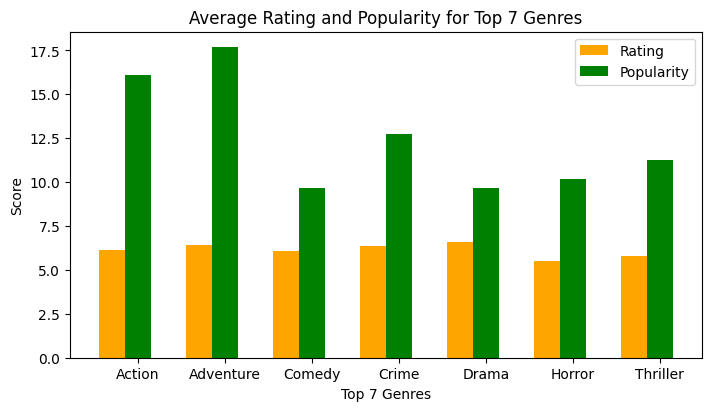

In [241]:
# Visualizing the top 7 genres and their average ratings
fig, ax = plt.subplots(figsize=(7,4), layout='constrained')

x = np.arange(len(top_7_genres_sorted))
y_rating = genre_tmdb['vote_average'].mean()
ax.bar(x - 0.3, y_rating, 0.3, color='orange', label='Rating')

y_popularity = genre_tmdb['popularity'].mean()
ax.bar(top_7_genres_sorted.keys(), y_popularity, 0.3, color='green', label='Popularity')


ax.set_title("Average Rating and Popularity for Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Score")
ax.legend()

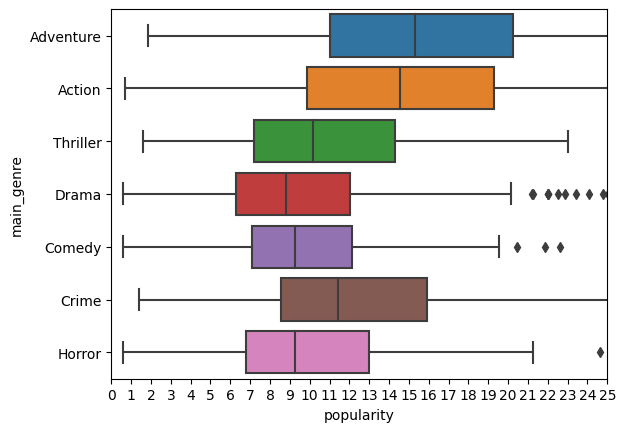

In [242]:
# Boxplot for popularity
top_7_genres_df = reviews_more_than_10.loc[reviews_more_than_10['main_genre'].isin(top_7_genres_index)]
top_7_genres_df['main_genre'].value_counts()

fig, ax = plt.subplots()
sns.boxplot(x=top_7_genres_df['popularity'], y=top_7_genres_df['main_genre'])
ax.set_xlim(0,25)
ax.set_xticks(range(0,26))
plt.show()

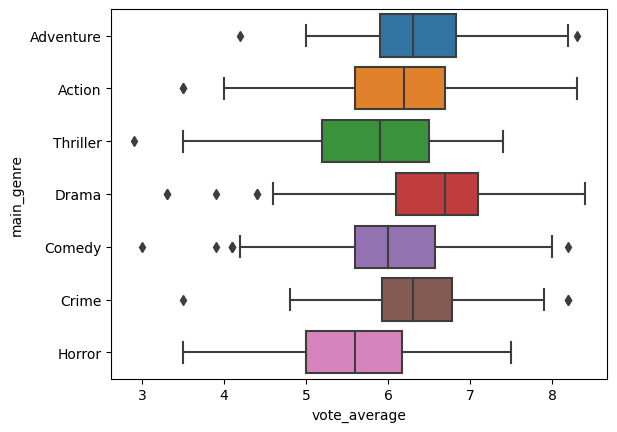

In [243]:
# Boxplot for vote average
fig, ax = plt.subplots()
sns.boxplot(x=top_7_genres_df['vote_average'], y=top_7_genres_df['main_genre'])
plt.show()

### Linear Regression

#### Cleaning data before modeling

In [244]:
# Removing null values before running linear regression
tmdb_movie['production_budget'].isna().sum()

tmdb_movie.dropna(subset='production_budget', inplace=True)
tmdb_movie['profit'].isna().sum()

0

In [245]:
# Changing values so that they are in millions for visualization
columns = ['production_budget', 'profit']

tmdb_movie[columns] = tmdb_movie[columns].apply(lambda x: x/1000000)
tmdb_movie[columns]

,production_budget,profit
0,165.0,329.870992
1,170.0,451.156389
2,160.0,675.524642
3,95.0,128.050874
4,200.0,868.879522
...,...,...
2054,25.0,9.356760
2055,25.0,9.356760
2056,25.0,9.356760
2057,38.0,12.970660


#### Simple linear regression model between production budget and profit

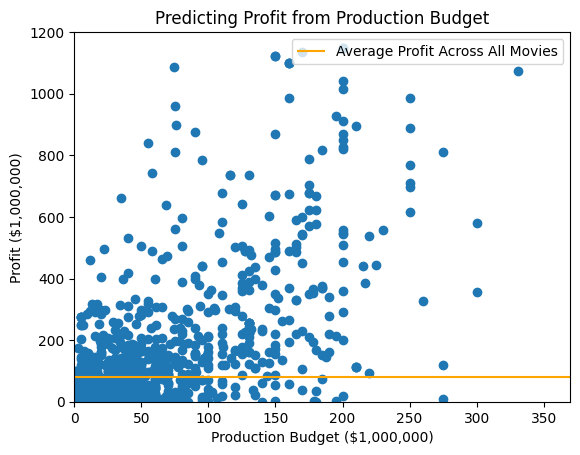

In [246]:
# Baseline model is the overall average profit across all movies 
X = tmdb_movie['production_budget'].values
y = tmdb_movie['profit'].values

plt.scatter(X, y)

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label="Average Profit Across All Movies",
            colors='orange')
plt.xlim([0,370])
plt.ylim([0,1200])
plt.title('Predicting Profit from Production Budget')
plt.xlabel('Production Budget ($1,000,000)')
plt.ylabel('Profit ($1,000,000)')
plt.legend()

In [247]:
lr = LinearRegression()

In [248]:
lr.fit(tmdb_movie[['production_budget']], y)

LinearRegression()

In [249]:
# Getting our linear regression model
m = lr.coef_
b = lr.intercept_
lm_model = m*tmdb_movie['production_budget'].values + b

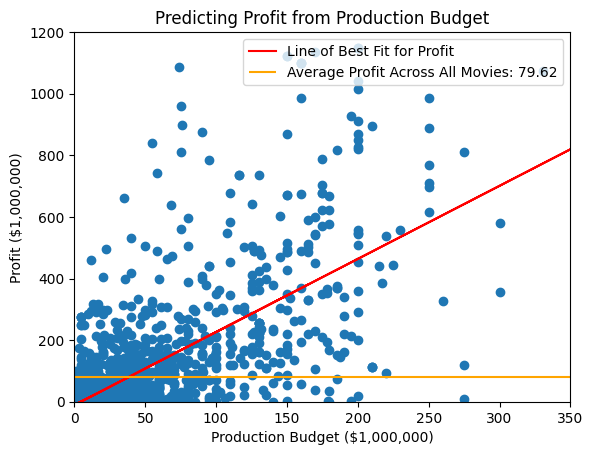

In [250]:
# Creating a scatter plot with the baseline model and the linear regression model
plt.scatter(X, y)
plt.plot(tmdb_movie['production_budget'].values, 
        lm_model, 
        label = 'Line of Best Fit for Profit',
        color='red')

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label=f"Average Profit Across All Movies: {y.mean():.2f}",
            colors='orange')

plt.xlim([0,350])
plt.ylim([0,1200])
plt.title('Predicting Profit from Production Budget')
plt.xlabel('Production Budget ($1,000,000)')
plt.ylabel('Profit ($1,000,000)')
plt.legend()
# same as this
# sns.lmplot(x='production_budget', y='worldwide_gross', data=tn_movie_budgets)

In [251]:
# Production budget prediction to result in average profit
pred_budget = (y.mean() - b)/m
pred_budget[0]

38.129132597863034

In [252]:
# Calculating metrics to evaluate the model
r2_score(y, lm_model)

0.4631982713370796

In [253]:
mean_squared_error(y, lm_model)

17165.476604872674

In [254]:
# Comparing with our baseline model,
# Which is the overall average profit
base_model = 0*tmdb_movie['production_budget'].values + y.mean()
r2_score(y, base_model)

0.0

In [255]:
mean_squared_error(y, base_model)

31977.31245692686

#### Group wise linear regression model per genre

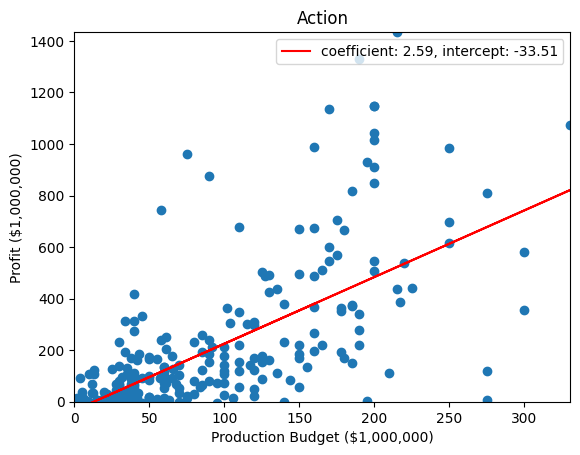

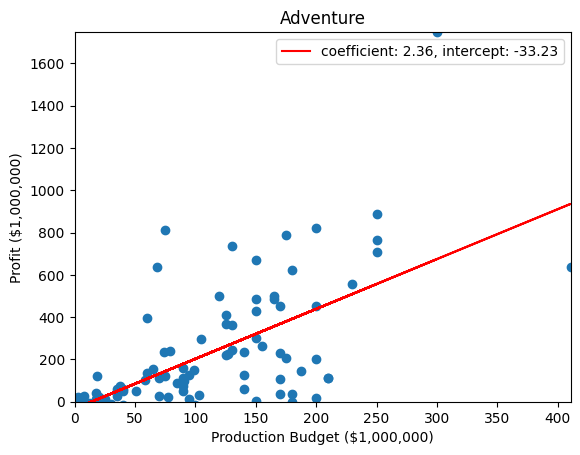

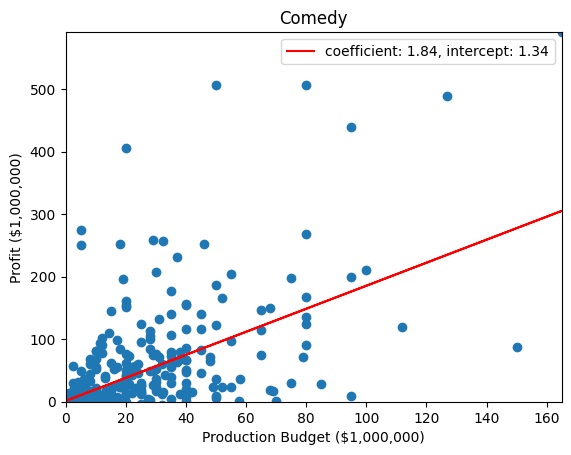

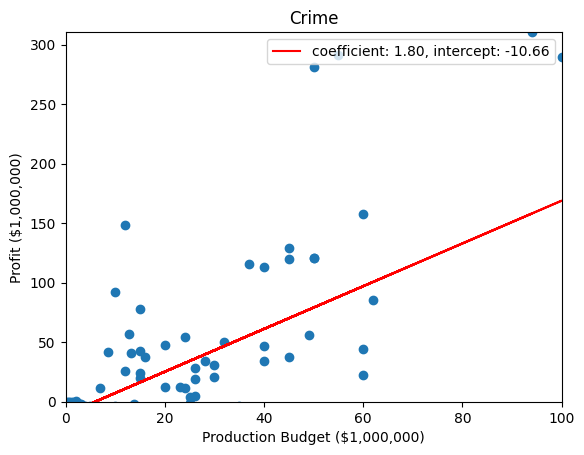

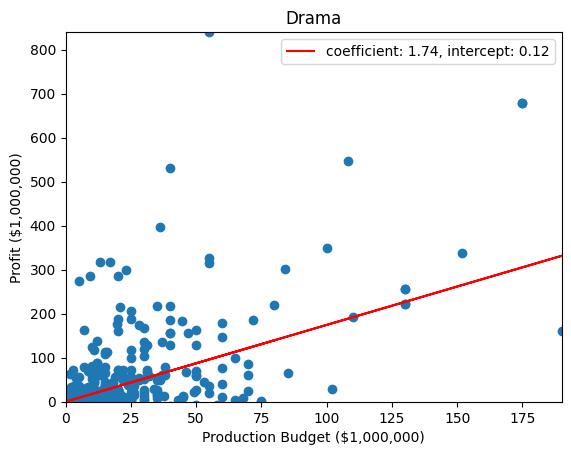

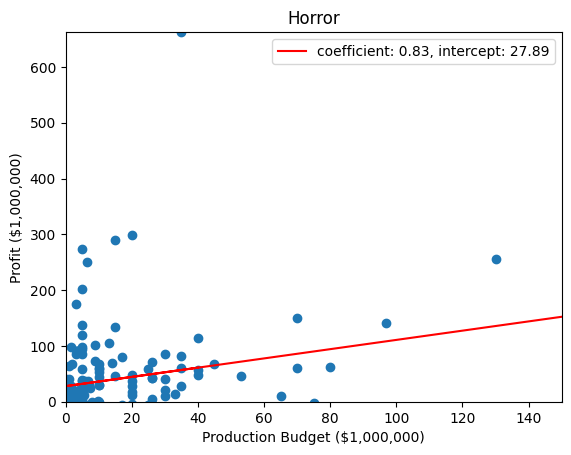

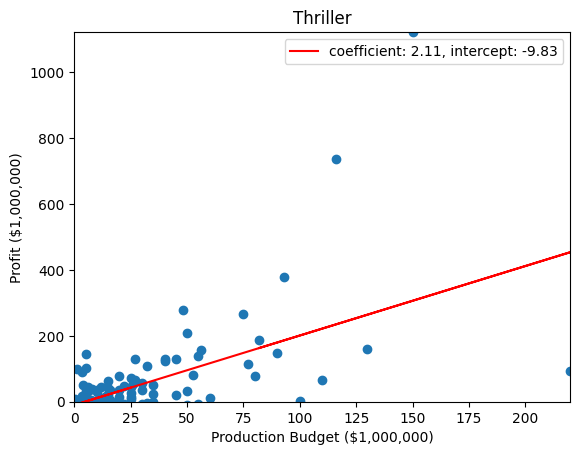

""


In [258]:
# Group wise linear regression and plot them individually
# Focusing on top 7 genres only
grouped_tmdb_movie = tmdb_movie.loc[tmdb_movie['main_genre'].isin(top_7_genres_index)].groupby(['main_genre'])

def model(df):
    y = df[['profit']].values
    X = df[['production_budget']].values
    lr = LinearRegression()
    lr.fit(X, y)
    m = lr.coef_
    b = lr.intercept_
    y_model = m*X + b
    plt.scatter(X,y)
    plt.plot(X, y_model, color='red', label=f"coefficient: {m[0][0]:.2f}, intercept: {b[0]:.2f}")
    plt.title(f"{df['main_genre'].values[0]}")
    plt.xlim([0,X.max()])
    plt.ylim([0,y.max()])
    plt.xlabel("Production Budget ($1,000,000)")
    plt.ylabel("Profit ($1,000,000)")
    plt.legend()
    plt.show()

grouped_tmdb_movie.apply(model)

### Release date and profit based on genre

In [259]:
# Extracting the release month
tmdb_movie['release_month'] = tmdb_movie['release_date_x'].str[5:7].astype(int)
tmdb_movie['release_month'].value_counts()

release_month
10    230
9     195
3     194
12    178
4     176
6     172
8     171
11    163
1     150
7     148
5     143
2     139
Name: count, dtype: int64

Text(0, 0.5, 'Profit ($ 1,000,000)')

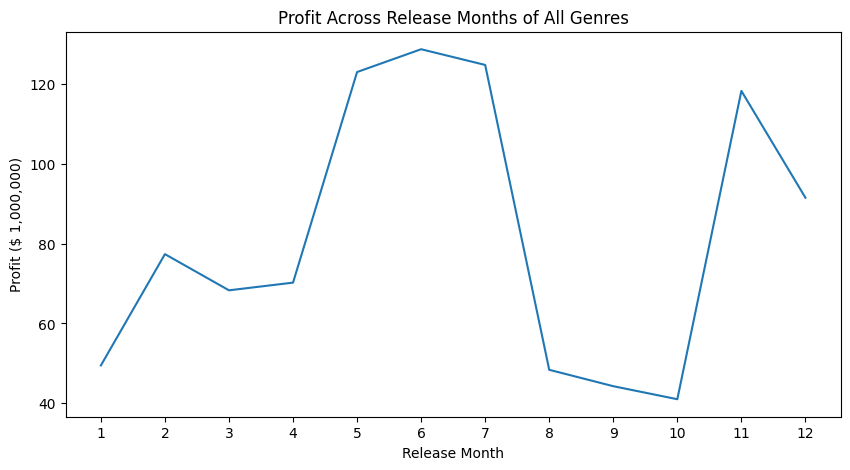

In [316]:
# Visualizing changing in profits across months
fig, ax = plt.subplots(figsize=(10,5))
x_profit = tmdb_movie['release_month'].value_counts().sort_index().index
y_profit = tmdb_movie.groupby('release_month')['profit'].mean()
ax.plot(x_profit, y_profit)
ax.set_xticks(range(1,13))
ax.set_title('Profit Across Release Months of All Genres')
ax.set_xlabel('Release Month')
ax.set_ylabel('Profit ($ 1,000,000)')

#### Separating profits across months per genre

In [299]:
grouped_genre_month = tmdb_movie.groupby('main_genre')

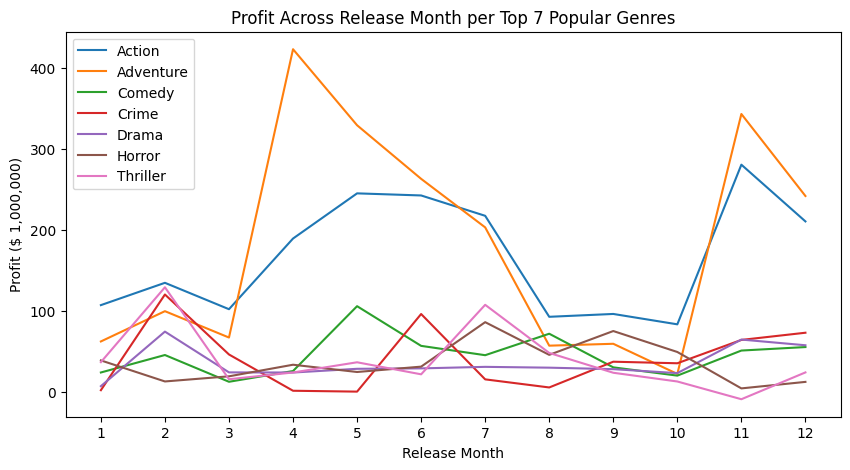

In [318]:
fig, ax = plt.subplots(figsize=(10,5))

for genre in top_7_genres_index:
        x_month = grouped_genre_month.get_group(genre)['release_month'].value_counts().sort_index().index
        y_month = grouped_genre_month.get_group(genre).groupby('release_month')['profit'].mean()
        ax.plot(x_month, y_month, label=f"{genre}")
ax.set_xticks(range(1,13))
ax.set_title('Profit Across Release Month per Top 7 Popular Genres')
ax.set_xlabel('Release Month')
ax.set_ylabel('Profit ($ 1,000,000)')
ax.legend()


In [320]:
tmdb_movie.to_csv("tmdb_with_release_month.csv")

## Rotten Tomatoes Database

In [28]:
reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding='latin1')
reviews['id'].value_counts()

id
782     338
1067    275
1525    262
1777    260
1083    260
       ... 
1393      1
411       1
770       1
1125      1
1526      1
Name: count, Length: 1135, dtype: int64

In [35]:
grouped_reviews = reviews.groupby('id')
grouped_reviews.count()['review'].describe()

count    1135.000000
mean       43.056388
std        56.670793
min         0.000000
25%         4.000000
50%        15.000000
75%        67.000000
max       338.000000
Name: review, dtype: float64

## SQLite IMDB

In order to unzip the database file, run the following prompt in terminal

`tar -xf "zippedData/im.db.zip"`

In [4]:
conn = sqlite3.connect("im.db")


In [4]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer
